In [1]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
base_image_path = 'http://guereak.com/nst/base_image_1.jpg'
style_reference_image_path_1 = 'http://guereak.com/nst/style_transfer_1.jpg'
style_reference_image_path_2 = 'http://guereak.com/nst/style_transfer_2.jpg'
style_reference_image_path_3 = 'http://guereak.com/nst/style_transfer_3.jpg'
style_reference_image_path_4 = 'http://guereak.com/nst/style_transfer_4.jpg'

style_reference_image_path = style_reference_image_path_3

1) Download and load the images

In [3]:
base_image_path = keras.utils.get_file(origin=base_image_path)
style_reference_image_path = keras.utils.get_file(origin=style_reference_image_path)

2128819/2128819 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step
5649/5649 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Set image dimensions
original_width, original_height = keras.utils.load_img(base_image_path).size
# img_height = 400  # Fixed height
# img_width = round(original_width * img_height / original_height)  # Maintain aspect ratio
img_height = 256
img_width = 256

In [23]:
def preprocess_image(image_path):
    """Loads and preprocesses an image with center cropping and RGB normalization."""
    img = Image.open(image_path).convert("RGB")
    width, height = img.size

    # Center crop to square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim
    img = img.crop((left, top, right, bottom))

    # Resize to target size
    img = img.resize((img_width, img_height))

    # Convert to array and normalize to [0, 1]
    img = np.array(img).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def deprocess_image(img):
    """Converts a normalized image (0–1 range) back to displayable uint8 RGB format."""
    img = img.reshape((img_height, img_width, 3))
    img = np.clip(img * 255.0, 0, 255).astype("uint8")
    return img

We check the original image:

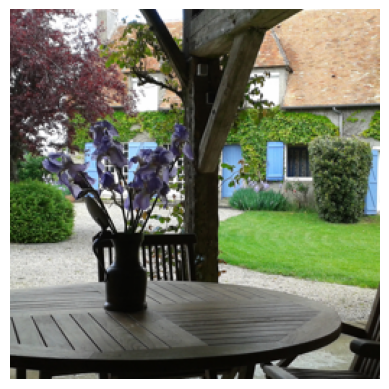

In [25]:
plt.imshow(preprocess_image(base_image_path).reshape((256, 256, 3)))
plt.axis('off')
plt.show()

### Try with our OWN (small) CNN: based on ResNet-18.



In [13]:
!pip -q install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from datasets import load_dataset
import numpy as np

# Ensure GPU is detected
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Load CIFAR10 Dataset from Hugging Face
dataset = load_dataset("uoft-cs/cifar10")

# Get class names
num_classes = 10

# Preprocess images
def preprocess_data(example):
    """Preprocesses a dataset example: resize & normalize."""
    image = example["img"].resize((32, 32)).convert("RGB")
    image = np.array(image) / 255.0  # Normalize
    label = to_categorical(example["label"], num_classes)
    return {"image": image, "label": label}

# Create tf.data pipeline
def prepare_dataset(split, batch_size=128, shuffle=True):
    ds = dataset[split].map(preprocess_data)
    ds = ds.to_tf_dataset(
        columns=["image"], label_cols=["label"], batch_size=batch_size, shuffle=shuffle
    )
    return ds

# Create train & validation datasets
batch_size = 128
train_dataset = prepare_dataset("train", batch_size=batch_size)
val_dataset = prepare_dataset("test", batch_size=batch_size, shuffle=False)

def FastTinyCNN(input_shape=(256, 256, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

# Load Model
model = FastTinyCNN(num_classes=num_classes)
model.summary()

# Compile Model
optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train Model
model.fit(
    train_dataset,
    epochs=5,  # Adjust based on available time
    validation_data=val_dataset,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# Save Final Model
model.save("fast_tiny_cnn_cifar10.h5")


Num GPUs Available: 1


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 32, 32, 32)          │             155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 16, 16, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 8, 8, 128)           │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,741 (49.77 KB)

 Trainable params: 12,741 (49.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.1555 - loss: 2.2063

391/391 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.1557 - loss: 2.2060 - val_accuracy: 0.2772 - val_loss: 1.9831 - learning_rate: 0.0010
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.2849 - loss: 1.9247

391/391 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.2849 - loss: 1.9246 - val_accuracy: 0.3284 - val_loss: 1.8259 - learning_rate: 0.0010
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.3326 - loss: 1.8140

391/391 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.3326 - loss: 1.8139 - val_accuracy: 0.3644 - val_loss: 1.7710 - learning_rate: 0.0010
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.3588 - loss: 1.7548

391/391 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.3588 - loss: 1.7548 - val_accuracy: 0.3881 - val_loss: 1.6885 - learning_rate: 0.0010
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.3867 - loss: 1.6946

391/391 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.3867 - loss: 1.6945 - val_accuracy: 0.4144 - val_loss: 1.6106 - learning_rate: 0.0010


For quick access: Load model from file

In [15]:
model = tf.keras.models.load_model("fast_tiny_cnn_cifar10.h5")

# Print model summary to verify
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 32, 32, 32)     │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 16, 16, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 8, 8, 128)      │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,743 (49.78 KB)

 Trainable params: 12,741 (49.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Using pretrained VGG19

In [ ]:
# Load pre-trained VGG19 model (without fully connected layers)
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

In [16]:
outputs_dict = {layer.name: layer.output for layer in model.layers}
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

No clue what these do:

In [17]:
def content_loss(base_img, combination_img):
    """Computes content loss (difference between base and generated image)."""
    return tf.reduce_sum(tf.square(combination_img - base_img))

def gram_matrix(x):
    """Computes Gram matrix for style representation."""
    x = tf.transpose(x, (2, 0, 1))  # Rearrange dimensions
    features = tf.reshape(x, (tf.shape(x)[0], -1))  # Flatten
    return tf.matmul(features, tf.transpose(features))

def style_loss(style_img, combination_img):
    """Computes style loss using Gram matrices."""
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    """Computes total variation loss for smoothness."""
    a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [18]:
# WORKS ONLY FOR TinyCNN. Do VGG instead

# Define layers for style and content extraction
style_layer_names = [
    "separable_conv2d_3", "separable_conv2d_4"
]
content_layer_name = "separable_conv2d_5"

# Define weights for the losses
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [19]:
def compute_loss(combination_image, base_image, style_reference_image):
    """Computes the total loss combining content, style, and variation losses."""
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())

    # Content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features, combination_features)

    # Style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        loss += (style_weight / len(style_layer_names)) * style_loss(style_reference_features, combination_features)

    # Total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)

    return loss

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    """Computes gradients for the optimization step."""
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## Load an optimizer: try various approaches

In [20]:
# TODO try other optimizers
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

## Time to run our code!

In [21]:
# Load and preprocess images
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

In [22]:
# Run optimization loop
iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

ValueError: in user code:

    File "<ipython-input-19-fdc98b252287>", line 29, in compute_loss_and_grads  *
        loss = compute_loss(combination_image, base_image, style_reference_image)
    File "<ipython-input-19-fdc98b252287>", line 4, in compute_loss  *
        features = feature_extractor(input_tensor)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/input_spec.py", line 245, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(3, 256, 256, 3)


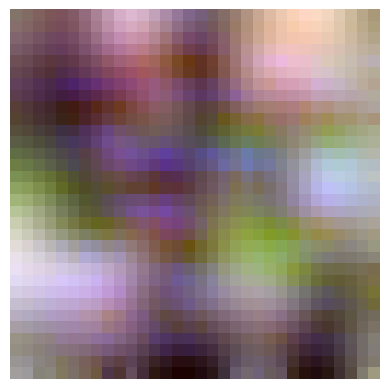

In [31]:
# Display final output
final_img_path = "combination_image_at_iteration_4000.png"
plt.imshow(keras.utils.load_img(final_img_path))
plt.axis('off')
plt.show()